In [76]:
# <!-- collapse=True -->
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [77]:
import numpy as np
import pandas as pd
from CoLoc_class import CoLoc, pseudocounts, make_EGmat, make_rca, make_PROXmat

import matplotlib.pylab as plt
import seaborn as sns

import string

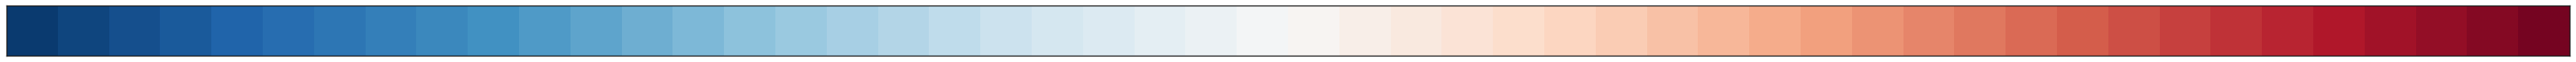

In [78]:
#define palette and set style for plots 
sns.set() 
sns.set_style('white')
cmap_div = sns.color_palette("RdBu_r", 50)

sns.palplot(cmap_div)

## Load the data

In [79]:
#major occupation groups 
df = pd.read_csv('BLS2016_clean.csv')

df = df.loc[df['OCC_GROUP']=='major']

df['OCC_TITLE'] = df['OCC_TITLE'].apply(lambda x: x[:-12])

#drop Farming and drop PR 
df = df[~df['OCC_CODE'].str.startswith('45')]
df = df[~df['AREA_NAME'].str.contains('PR')]

df = df.pivot(index = 'AREA_NAME', columns ='OCC_TITLE', values = 'TOT_EMP').fillna(0)

#sort occs by size 
sorted_occix = np.argsort(df.sum(0).values)

#sort MSA's by size 
sorted_MSAix = np.argsort(df.sum(1).values)

df = df.iloc[sorted_MSAix,sorted_occix]

major_df = df/10 #note that we divide by 10 the data, assuming it is generated per 10 

In [80]:
#detailed occupation groups 
df = pd.read_csv('BLS2016_clean.csv')

df = df.loc[df['OCC_GROUP']=='detailed']

#drop Farming and drop PR 
df = df[~df['OCC_CODE'].str.startswith('45')] # != 'Farming, Fishing, and Forestry'] 
df = df[~df['AREA_NAME'].str.contains('PR')]

df = df.pivot(index = 'AREA_NAME', columns ='OCC_TITLE', values = 'TOT_EMP').fillna(0)

#sort occs by size 
sorted_occix = np.argsort(df.sum(0).values)[::-1]

#sort MSA's by size 
sorted_MSAix = np.argsort(df.sum(1).values)[::-1]

df = df.iloc[sorted_MSAix,sorted_occix]

detailed_df = df.loc[:,df.sum(0)>df.sum(0).quantile(.1)]/10 #remove smallest ten percent occupations, and assume data is generated per 10 

## Figure 1 - describe general patterns

- A heatmap of PMIci  (= log RCA) 
- B heatmap of PMIij (colocation) 
- C KLpc_i (localization)
- D KLpj_i (co-dependence)

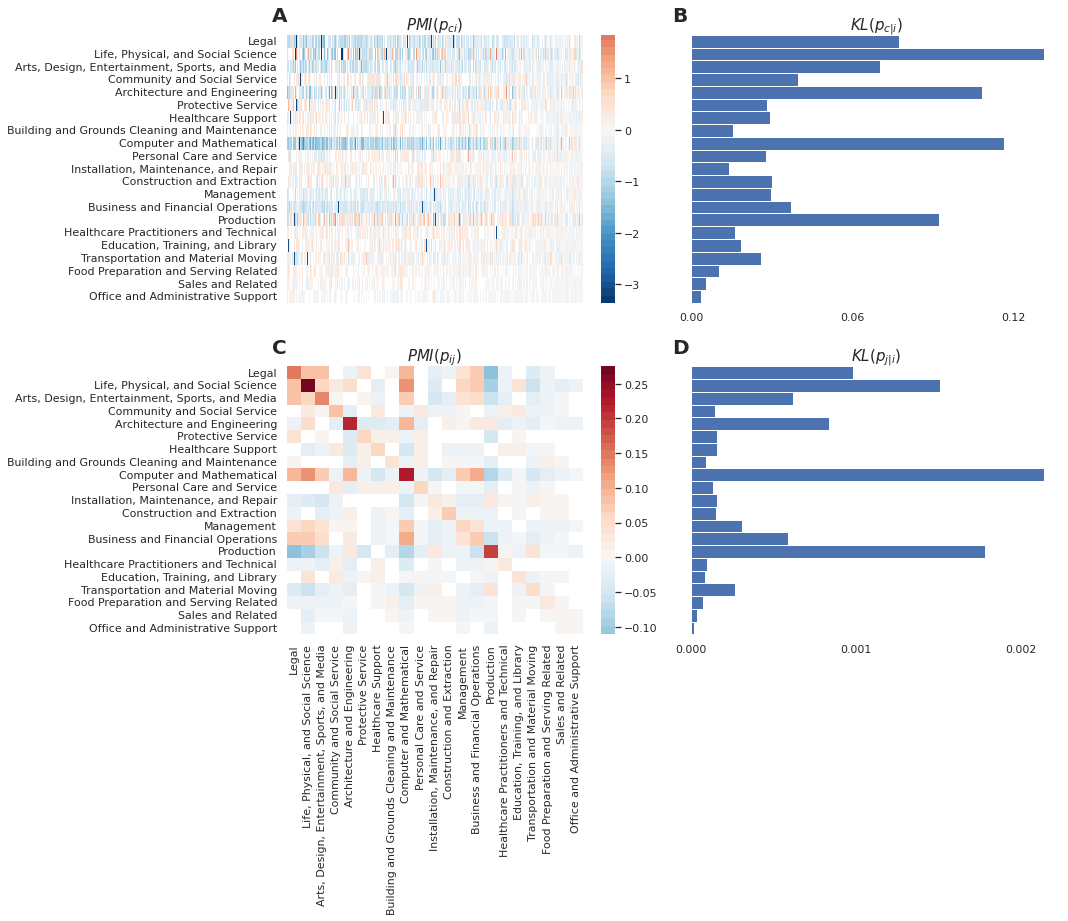

In [81]:
perc = .05 #prior weight 
nr_prior_obs = major_df.sum().sum()*perc / (1-perc)   #nr of pseudocounts equivalent to prior weight 
alpha = 0.05

Q = CoLoc(major_df, 'prop', nr_prior_obs = nr_prior_obs)  

PMIpci = Q.make_sigPMIpci()
PMIpij = Q.make_sigPMIpij()

KLpc_i = Q.make_KLpc_i()
KLpj_i = Q.make_KLpj_i()


fig, ax = plt.subplots(ncols = 2,nrows = 2, figsize = (15,13))
    
sns.heatmap(PMIpci.T,ax = ax[0,0],center = 0, cmap = cmap_div, xticklabels = False)
sns.heatmap(PMIpij,ax = ax[1,0],center = 0, cmap = cmap_div)


ax[0,1].barh(range(len(KLpc_i)) ,KLpc_i.values, height = 1, align = 'edge')
ax[1,1].barh(range(len(KLpj_i)) ,KLpj_i.values, height = 1, align = 'edge')


#remove labels 
ax[0,0].set_xlabel(None)   
ax[1,0].set_xlabel(None)   
ax[0,0].set_ylabel(None)   
ax[1,0].set_ylabel(None)   

#set titles
ax[0,0].set_title('$PMI(p_{ci})$', fontsize = 15)   
ax[1,0].set_title('$PMI(p_{ij})$', fontsize = 15)   
ax[0,1].set_title('$KL(p_{c|i})$', fontsize = 15)      
ax[1,1].set_title('$KL(p_{j|i})$', fontsize = 15)   

#format axes 
ax[0,1].get_yaxis().set_visible(False)
ax[1,1].get_yaxis().set_visible(False)
ax[0,1].set_frame_on(False)
ax[1,1].set_frame_on(False)


#fix axes ticks 
ax[1,1].set_xticks(np.linspace(0,0.002,3))
ax[0,1].set_xticks(np.linspace(0,0.12,3))

ax[0,1].set_ylim(ax[1,0].get_ylim())
ax[1,1].set_ylim(ax[1,0].get_ylim())

#annotate subplots 
for n,x in enumerate(ax.flatten()):
    x.text(-0.05, 1.05, string.ascii_uppercase[n], transform=x.transAxes, size=20, weight='bold')

plt.tight_layout()

plt.savefig('./figures/BLS_major.png', bbox_inches = 'tight', dpi=300)

## Figure 2: Compare colocations to EG co-agglomeration and Hidalgo's proximity, using heatmaps

- A: heatmap of PMIpij 
- B: heatmap of Ellison-Gleaser co-agglomeration 
- C: heatmap of proximity (Hidalgo etal., 2007)

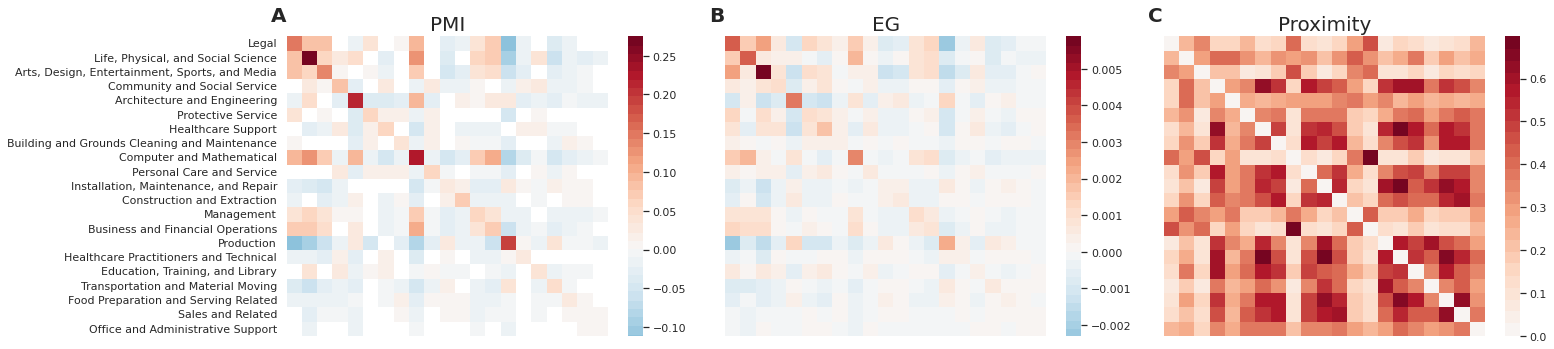

In [82]:
#define the dataframes containg colocation measures
EGij = make_EGmat(major_df)
PROXij =  make_PROXmat(major_df)
PMIpij = Q.make_sigPMIpij()

fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (22,5))

sns.heatmap(PMIpij, ax = ax[0],center = 0, cmap = cmap_div, yticklabels = True, xticklabels = False)
sns.heatmap(EGij, ax = ax[1],center = 0, cmap = cmap_div, yticklabels = False,  xticklabels = False)#, robust = True)
sns.heatmap(PROXij, ax = ax[2],center = 0, cmap = cmap_div, yticklabels = False, xticklabels = False)#, robust = True)

#set titles 
ax[0].set_title('PMI', fontsize = 20)
ax[1].set_title('EG', fontsize = 20)
ax[2].set_title('Proximity', fontsize = 20)

#annotate subplots and set the labels 
for n,x in enumerate(ax.flatten()):
    x.text(-0.05, 1.05, string.ascii_uppercase[n], transform=x.transAxes, size=20, weight='bold')
    x.set_xlabel(None)   
    x.set_ylabel(None)   
    

plt.tight_layout() 

    
plt.savefig('./figures/heatmaps.png', bbox_inches = 'tight', dpi=300)

In [83]:
#create long dataframes with associations for major occupations groups 

perc = .05
nr_prior_obs = major_df.sum().sum()*perc / (1-perc) 
Q = CoLoc(major_df, 'prop', nr_prior_obs = nr_prior_obs)

PMIpij = Q.make_PMIpij()
insigPMIpij = Q.make_insigPMIpij()



comp_df = PMIpij.where(np.triu(np.ones(PMIpij.shape),1)==1).stack().to_frame(name= 'PMI').join(EGij.stack().to_frame('EG')).join(PROXij.stack().to_frame('proximity'))
comp_df = comp_df.join(insigPMIpij.isna().stack().to_frame(name = 'sig'))
comp_df.index = comp_df.index.set_names(['occupation 1', 'occupation 2'])
comp_df = comp_df.sort_values('sig', ascending = False)

label = comp_df['sig'].apply(lambda x: 'significant' if x else 'insignificant')

#create long dataframes with associations for major occupations groups 

perc = .05
nr_prior_obs = detailed_df.sum().sum()*perc / (1-perc) 
Q_d = CoLoc(detailed_df, 'prop', nr_prior_obs = nr_prior_obs)

PMIpij_d = Q_d.make_PMIpij()
insigPMIpij_d = Q_d.make_insigPMIpij()

EGij_d = make_EGmat(detailed_df)
PROXij_d =  make_PROXmat(detailed_df)


comp_df_d = PMIpij_d.where(np.triu(np.ones(PMIpij_d.shape),1)==1).stack().to_frame(name= 'PMI').join(EGij_d.stack().to_frame('EG')).join(PROXij_d.stack().to_frame('proximity'))
comp_df_d = comp_df_d.join(insigPMIpij_d.isna().stack().to_frame(name = 'sig'))
comp_df_d.index = comp_df_d.index.set_names(['occupation 1', 'occupation 2'])
comp_df_d = comp_df_d.sort_values('sig', ascending = False)

label_d = comp_df_d['sig'].apply(lambda x: 'significant' if x else 'insignificant')

## Create tables for major occupation groups 

- Top and bottom 5 co-location by PMI 
- Top 5 co-location by EG
- Top 5 co-location by proximity

In [84]:
print('\n \t Occccupation pairs sorted by PMI')
display(comp_df.sort_values('PMI', ascending = False))

print('\n \t Top 5 co-agglomerations for insignificant associations')
display(comp_df[comp_df['sig']==False].sort_values('EG', ascending = False).head(5))

print('\n \t Top 5 proximities for insignificant associations')
display(comp_df[comp_df['sig']==False].sort_values('proximity', ascending = False).head(5))


x = comp_df.sort_values('PMI', ascending = False)
x = pd.concat([x.head(5),x.tail(5)])
x['significant'] = x['sig'].apply(lambda x: 'Yes' if x else 'No')
x = x.drop(columns = 'sig')
x = x.rename(columns = {'PMI':'$PMI(p_{ij})$'})
x = x.rename_axis(index = {'OCC_TITLE':'occupation'})
x = x.style.format(precision = 3) 

#format to latex 
print(x.to_latex(position = 'h', label = 'tab:PMIij_sig', caption = 'Top 5 and bottom 5 co-location pairs by PMI, excluding self-associations' ))


x = comp_df[comp_df['sig']==False].sort_values('EG', ascending = False).head(5)
x['significant'] = x['sig'].apply(lambda x: 'Yes' if x else 'No')
x = x.drop(columns = 'sig')
x = x.rename(columns = {'PMI':'$PMI(p_{ij})$'})
x = x.rename_axis(index = {'OCC_TITLE':'occupation'})
x = x.style.format(precision = 3) 

#format to latex
print(x.to_latex( position = 'h', label = 'tab:EG_insig',caption = 'Top 5 co-location pairs by EG for insignificant associations' ))


x = comp_df[comp_df['sig']==False].sort_values('proximity', ascending = False).head(5)
x['significant'] = x['sig'].apply(lambda x: 'Yes' if x else 'No')
x = x.drop(columns = 'sig')
x = x.rename(columns = {'PMI':'$PMI(p_{ij})$'})
x = x.rename_axis(index = {'OCC_TITLE':'occupation'})
x = x.style.format(precision = 3) 

#format to latex 
print(x.to_latex(position = 'h', label = 'tab:prox_insig', caption = 'Top 5 co-location pairs by proximity for insignificant associations' ))


 	 Occccupation pairs sorted by PMI


PMI  \
occupation 1                       occupation 2                                   
Life, Physical, and Social Science Computer and Mathematical           0.128838   
Computer and Mathematical          Business and Financial Operations   0.101105   
Architecture and Engineering       Computer and Mathematical           0.098140   
Legal                              Computer and Mathematical           0.095457   
                                   Life, Physical, and Social Science  0.078761   
...                                                                         ...   
Business and Financial Operations  Production                         -0.057438   
Life, Physical, and Social Science Transportation and Material Moving -0.058590   
Computer and Mathematical          Production                         -0.085954   
Life, Physical, and Social Science Production                         -0.096046   
Legal                              Production                         -0.111077   

                                                                             EG  \
occupation 1                       occupation 2                                   
Life, Physical, and Social Science Computer and Mathematical           0.002027   
Computer and Mathematical          Business and Financial Operations   0.001180   
Architecture and Engineering       Computer and Mathematical           0.000799   
Legal                              Computer and Mathematical           0.001448   
                                   Life, Physical, and Social Science  0.001621   
...                                                                         ...   
Business and Financial Operations  Production                         -0.000846   
Life, Physical, and Social Science Transportation and Material Moving -0.000777   
Computer and Mathematical          Production                         -0.000860   
Life, Physical, and Social Science Production                         -0.000901   
Legal                              Production                         -0.002293   

                                                                       proximity  \
occupation 1                       occupation 2                                    
Life, Physical, and Social Science Computer and Mathematical            0.288136   
Computer and Mathematical          Business and Financial Operations    0.698630   
Architecture and Engineering       Computer and Mathematical            0.299213   
Legal                              Computer and Mathematical            0.393939   
                                   Life, Physical, and Social Science   0.237288   
...                                                                          ...   
Business and Financial Operations  Production                           0.126168   
Life, Physical, and Social Science Transportation and Material Moving   0.184971   
Computer and Mathematical          Production                           0.102804   
Life, Physical, and Social Science Production                           0.205607   
Legal                              Production                           0.065421   

                                                                        sig  
occupation 1                       occupation 2                              
Life, Physical, and Social Science Computer and Mathematical           True  
Computer and Mathematical          Business and Financial Operations   True  
Architecture and Engineering       Computer and Mathematical           True  
Legal                              Computer and Mathematical           True  
                                   Life, Physical, and Social Science  True  
...                                                                     ...  
Business and Financial Operations  Production                          True  
Life, Physical, and Social Science Transportation and Material Moving  True  
Computer and Mathematical          Producti


 	 Top 5 co-agglomerations for insignificant associations


PMI  \
occupation 1                                   occupation 2                                      
Legal                                          Healthcare Support                    -0.004950   
                                               Education, Training, and Library      -0.001588   
Arts, Design, Entertainment, Sports, and Media Education, Training, and Library       0.001931   
Legal                                          Community and Social Service           0.002666   
Architecture and Engineering                   Installation, Maintenance, and Repair  0.000337   

                                                                                            EG  \
occupation 1                                   occupation 2                                      
Legal                                          Healthcare Support                     0.000898   
                                               Education, Training, and Library       0.000527   
Arts, Design, Entertainment, Sports, and Media Education, Training, and Library       0.000516   
Legal                                          Community and Social Service           0.000508   
Architecture and Engineering                   Installation, Maintenance, and Repair  0.000425   

                                                                                      proximity  \
occupation 1                                   occupation 2                                       
Legal                                          Healthcare Support                      0.126214   
                                               Education, Training, and Library        0.129353   
Arts, Design, Entertainment, Sports, and Media Education, Training, and Library        0.169154   
Legal                                          Community and Social Service            0.162679   
Architecture and Engineering                   Installation, Maintenance, and Repair   0.303887   

                                                                                        sig  
occupation 1                                   occupation 2                                  
Legal                                          Healthcare Support                     False  
                                               Education, Training, and Library       False  
Arts, Design, Entertainment, Sports, and Media Education, Training, and Library       False  
Legal                                          Community and Social Service           False  
Architecture and Engineering                   Installation, Maintenance, and Repair  False


 	 Top 5 proximities for insignificant associations


PMI  \
occupation 1                                  occupation 2                                      
Healthcare Practitioners and Technical        Food Preparation and Serving Related   0.001314   
                                              Sales and Related                      0.000958   
Healthcare Support                            Production                            -0.002448   
                                              Installation, Maintenance, and Repair -0.000130   
Building and Grounds Cleaning and Maintenance Education, Training, and Library       0.000868   

                                                                                           EG  \
occupation 1                                  occupation 2                                      
Healthcare Practitioners and Technical        Food Preparation and Serving Related   0.000063   
                                              Sales and Related                      0.000028   
Healthcare Support                            Production                            -0.001059   
                                              Installation, Maintenance, and Repair -0.000320   
Building and Grounds Cleaning and Maintenance Education, Training, and Library       0.000121   

                                                                                     proximity  \
occupation 1                                  occupation 2                                       
Healthcare Practitioners and Technical        Food Preparation and Serving Related    0.645161   
                                              Sales and Related                       0.544355   
Healthcare Support                            Production                              0.542056   
                                              Installation, Maintenance, and Repair   0.537102   
Building and Grounds Cleaning and Maintenance Education, Training, and Library        0.522388   

                                                                                       sig  
occupation 1                                  occupation 2                                  
Healthcare Practitioners and Technical        Food Preparation and Serving Related   False  
                                              Sales and Related                      False  
Healthcare Support                            Production                             False  
                                              Installation, Maintenance, and Repair  False  
Building and Grounds Cleaning and Maintenance Education, Training, and Library       False

\begin{table}[h]
\caption{Top 5 and bottom 5 co-location pairs by PMI, excluding self-associations}
\label{tab:PMIij_sig}
\begin{tabular}{llrrrl}
 &  & $PMI(p_{ij})$ & EG & proximity & significant \\
occupation 1 & occupation 2 &  &  &  &  \\
Life, Physical, and Social Science & Computer and Mathematical & 0.129 & 0.002 & 0.288 & Yes \\
Computer and Mathematical & Business and Financial Operations & 0.101 & 0.001 & 0.699 & Yes \\
Architecture and Engineering & Computer and Mathematical & 0.098 & 0.001 & 0.299 & Yes \\
\multirow[c]{2}{*}{Legal} & Computer and Mathematical & 0.095 & 0.001 & 0.394 & Yes \\
 & Life, Physical, and Social Science & 0.079 & 0.002 & 0.237 & Yes \\
Business and Financial Operations & Production & -0.057 & -0.001 & 0.126 & Yes \\
Life, Physical, and Social Science & Transportation and Material Moving & -0.059 & -0.001 & 0.185 & Yes \\
Computer and Mathematical & Production & -0.086 & -0.001 & 0.103 & Yes \\
Life, Physical, and Social Science & Production & -0.09

## Create tables for detailed occupation groups 

- Top 10 co-location by EG
- Top 10 co-location by PMI

In [85]:
#make top 10 

display(comp_df_d.drop(columns = 'sig').sort_values('EG', ascending = False).head(10))

display(comp_df.drop(columns = 'sig').sort_values('PMI', ascending = False).head(10))


x = comp_df_d.sort_values('EG', ascending = False).head(10)
x = x.drop(columns = 'sig')
x = x.rename(columns = {'PMI':'$PMI(p_{ij})$'})
x = x.style.format(precision = 3) 

#format to latex table 
print(x.to_latex(position = 'h', label = 'tab:detailed_EG', caption = 'Top 10 co-location pairs by EG for detailed occupations' ))



x = comp_df.sort_values('PMI', ascending = False).head(10)
x = x.drop(columns = 'sig')
x = x.rename(columns = {'PMI':'$PMI(p_{ij})$'})
x = x.style.format(precision = 3) 

#format to latex table 
print(x.to_latex(position = 'h', label = 'tab:detailed_PMI', caption = 'Top 10 co-location pairs by PMI for detailed occupations' ))


,,PMI,EG,proximity
occupation 1,occupation 2,,,
Economists,Political Scientists,2.872716,0.481165,0.066667
Rail-Track Laying and Maintenance Equipment Operators,Railroad Conductors and Yardmasters,1.843546,0.427311,0.111111
Subway and Streetcar Operators,Railroad Conductors and Yardmasters,1.820956,0.419380,0.333333
Barbers,Railroad Conductors and Yardmasters,1.707056,0.363093,0.250000
Political Scientists,"Artists and Related Workers, All Other",2.612547,0.359992,0.133333
Fashion Designers,Railroad Conductors and Yardmasters,1.668101,0.339225,0.090909
Railroad Conductors and Yardmasters,Costume Attendants,1.610970,0.325078,0.052632
"Grounds Maintenance Workers, All Other",Railroad Conductors and Yardmasters,1.499885,0.280216,0.043478
Railroad Conductors and Yardmasters,Fabric and Apparel Patternmakers,1.478600,0.262673,0.111111


PMI  \
occupation 1                                   occupation 2                                               
Life, Physical, and Social Science             Computer and Mathematical                       0.128838   
Computer and Mathematical                      Business and Financial Operations               0.101105   
Architecture and Engineering                   Computer and Mathematical                       0.098140   
Legal                                          Computer and Mathematical                       0.095457   
                                               Life, Physical, and Social Science              0.078761   
                                               Arts, Design, Entertainment, Sports, and Media  0.077882   
                                               Business and Financial Operations               0.074247   
Computer and Mathematical                      Management                                      0.068625   
Arts, Design, Entertainment, Sports, and Media Computer and Mathematical                       0.068588   
Life, Physical, and Social Science             Business and Financial Operations               0.067457   

                                                                                                     EG  \
occupation 1                                   occupation 2                                               
Life, Physical, and Social Science             Computer and Mathematical                       0.002027   
Computer and Mathematical                      Business and Financial Operations               0.001180   
Architecture and Engineering                   Computer and Mathematical                       0.000799   
Legal                                          Computer and Mathematical                       0.001448   
                                               Life, Physical, and Social Science              0.001621   
                                               Arts, Design, Entertainment, Sports, and Media  0.002444   
                                               Business and Financial Operations               0.001401   
Computer and Mathematical                      Management                                      0.000918   
Arts, Design, Entertainment, Sports, and Media Computer and Mathematical                       0.000414   
Life, Physical, and Social Science             Business and Financial Operations               0.001043   

                                                                                               proximity  
occupation 1                                   occupation 2                                               
Life, Physical, and Social Science             Computer and Mathematical                        0.288136  
Computer and Mathematical                      Business and Financial Operations                0.698630  
Architecture and Engineering                   Computer and Mathematical                        0.299213  
Legal                                          Computer and Mathematical                        0.393939  
                                               Life, Physical, and Social Science               0.237288  
                                               Arts, Design, Entertainment, Sports, and Media   0.350000  
                                               Business and Financial Operations                0.452055  
Computer and Mathematical                      Management                                       0.375000  
Arts, Design, Entertainment, Sports, and Media Computer and Mathematical                        0.454545  
Life, Physical, and Social Science             Business and Financial Operations                0.313559

\begin{table}[h]
\caption{Top 10 co-location pairs by EG for detailed occupations}
\label{tab:detailed_EG}
\begin{tabular}{llrrr}
 &  & $PMI(p_{ij})$ & EG & proximity \\
occupation 1 & occupation 2 &  &  &  \\
Economists & Political Scientists & 2.873 & 0.481 & 0.067 \\
Rail-Track Laying and Maintenance Equipment Operators & Railroad Conductors and Yardmasters & 1.844 & 0.427 & 0.111 \\
Subway and Streetcar Operators & Railroad Conductors and Yardmasters & 1.821 & 0.419 & 0.333 \\
Barbers & Railroad Conductors and Yardmasters & 1.707 & 0.363 & 0.250 \\
Political Scientists & Artists and Related Workers, All Other & 2.613 & 0.360 & 0.133 \\
Fashion Designers & Railroad Conductors and Yardmasters & 1.668 & 0.339 & 0.091 \\
Railroad Conductors and Yardmasters & Costume Attendants & 1.611 & 0.325 & 0.053 \\
Grounds Maintenance Workers, All Other & Railroad Conductors and Yardmasters & 1.500 & 0.280 & 0.043 \\
Railroad Conductors and Yardmasters & Fabric and Apparel Patternmakers & 1.479 & 

## Figure 3: Scatter plots of co-location associations for major and detailed occupation groups

- A: PMI vs EG (major) 
- B: PMI vs proximity (major) 
- C: PMI vs EG (detailed) 
- D: PMI vs EG (detailed) 

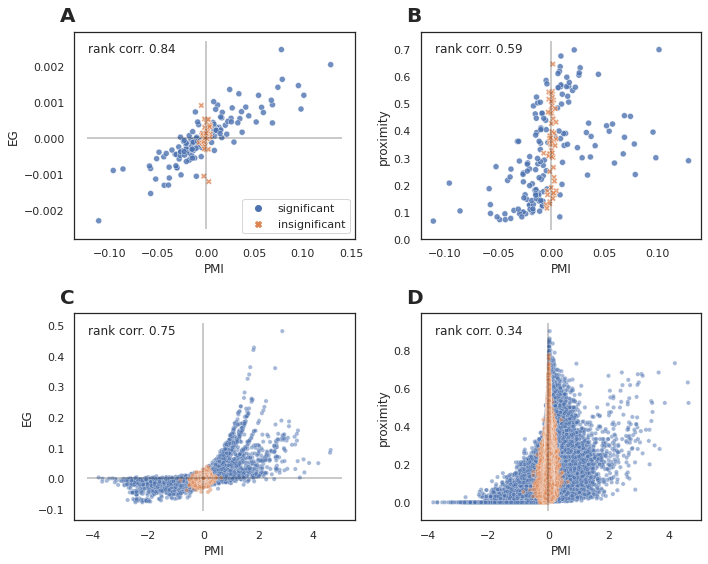

In [86]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (10,8))

sns.scatterplot(ax = ax[0,0], data = comp_df, hue = label, style = label, style_order = ['significant', 'insignificant'], hue_order = ['significant', 'insignificant'], x = 'PMI' ,y = 'EG', alpha = .8)
sns.scatterplot(ax = ax[0,1], data = comp_df, hue = label, style = label, style_order = ['significant', 'insignificant'], hue_order = ['significant', 'insignificant'], x = 'PMI' ,y = 'proximity', alpha = .8)

sns.scatterplot(ax = ax[1,0], data = comp_df_d, hue = label_d,  hue_order = ['significant', 'insignificant'], x = 'PMI' ,y = 'EG', alpha = .5, size = 3)
sns.scatterplot(ax = ax[1,1], data = comp_df_d, hue = label_d,  hue_order = ['significant', 'insignificant'], x = 'PMI' ,y = 'proximity', alpha = .5, size = 3)

    
ax[0,0].hlines(0,xmin = ax[0,0].get_xlim()[0], xmax = ax[0,0].get_xlim()[1], alpha = .3, color = 'k')
ax[0,0].vlines(0,ymin = ax[0,0].get_ylim()[0], ymax = ax[0,0].get_ylim()[1], alpha = .3, color = 'k')

ax[0,1].vlines(0,ymin = ax[0,1].get_ylim()[0], ymax = ax[0,1].get_ylim()[1], alpha = .3, color = 'k')

ax[1,0].hlines(0,xmin = ax[1,0].get_xlim()[0], xmax = ax[1,0].get_xlim()[1], alpha = .3, color = 'k')
ax[1,0].vlines(0,ymin = ax[1,0].get_ylim()[0], ymax = ax[1,0].get_ylim()[1], alpha = .3, color = 'k')

ax[1,1].vlines(0,ymin = ax[1,1].get_ylim()[0], ymax = ax[1,1].get_ylim()[1], alpha = .3, color = 'k')

ax[0,1].set_ylim(ymin=0)

ax[0,0].legend(loc='lower right')

for x in ax.flatten()[1::]:
    x.legend_ = None

for n,x in enumerate(ax.flatten()):
    x.text(-0.05, 1.05, string.ascii_uppercase[n], transform=x.transAxes, size=20, weight='bold')

    
#compute correlations for inset 
corrs = pd.concat([comp_df.loc[:,['PMI','EG', 'proximity']].corr(method = 'spearman').iloc[0,1::],comp_df_d.loc[:,['PMI','EG', 'proximity']].corr(method = 'spearman').iloc[0,1::]])
    
for x,r in zip(ax.flatten(),corrs):
    x.text(0.05,.90,f'rank corr. {r:.2f}',transform=x.transAxes, size=12)
    
    
plt.tight_layout()


plt.savefig('./figures/PMI_EG_prox_scatters_d.png', bbox_inches = 'tight', dpi=300)

## Figure 4: Relation between localization and ubiquity, and ubiquity and proximity (detailed occupation groups) 

- A: localization vs ubiquity 
- B: minimum ubiquity of occupation pair vs proximity of pair 

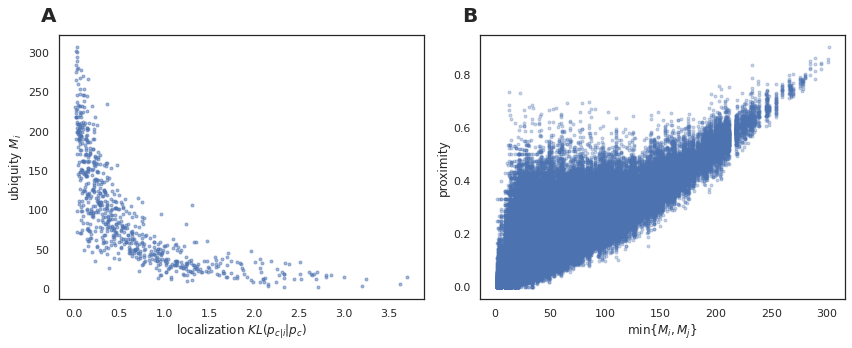

In [87]:
fig, ax = plt.subplots(ncols = 2, figsize = (12,5))

#compute proxmities 
PROXij_d = make_PROXmat(detailed_df) 
proximities = PROXij_d.where(np.triu(np.ones((Q_d.Ni,Q_d.Ni))==1,1)).stack().values

#compute ubiquities 
ubiqs = make_rca(detailed_df, binary = True).sum(0).values
min_ubiq = pd.DataFrame(np.minimum(ubiqs[:,None], ubiqs)).where(np.triu(np.ones((Q_d.Ni,Q_d.Ni))==1,1)).stack().values


ax[0].plot(Q_d.make_KLpc_i(),ubiqs,'.', alpha = .5)
ax[0].set_xlabel(r'localization $KL(p_{c|i}|p_c)$')
ax[0].set_ylabel(r'ubiquity $M_i$')


ax[1].plot(min_ubiq, proximities,'.',alpha = .3 )
ax[1].set_xlabel(r'$\min\{M_i,M_j\}$')
ax[1].set_ylabel('proximity')

#annotate subplots 
for n,x in enumerate(ax.flatten()):
    x.text(-0.05, 1.05, string.ascii_uppercase[n], transform=x.transAxes, size=20, weight='bold')

    
plt.tight_layout()

plt.savefig('./figures/prox_bias_scatters.png', bbox_inches = 'tight', dpi=300)